# Classification Predict

## Table of Contents


1. [Introduction](#1.-Introduction)
    - Problem statement
    - Objective
    
2. [Importing Packages](#2.-Importing-Packages)

3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
    - Load Data 
    
4. [Pre-processing](#4.-Pre-processing)
    - [Removing the Noise](#Removing-the-Noise)
       - Lowercasing the Data 
       - Removing Contractions
       - Removing Punctuation
       - Removing Numbers 
       - Removing Extra Space
       - Replacing Repetition of punctuation
       - Removing Emojis
       - Removing Emoticons
       - Removing Stop Words
       
    
5. [Feature Engineering](#5.-Feature-Engineering)
    - Bag of Words
    - N-grams
        
6. [Modelling](#6.-Modelling)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction
[Back to Table of Contents](#Table-of-Contents)

###  Problem Statement

Many companies would like to determine how their customers perceive climate change and whether or not they believe it is a real threat. 
Knowledge of this would add to their market research efforts in gauging how their product/service may be received.

An accurate and robust solution to this problem would give the companies access to a broad understanding of consumer sentiment, spanning multiple demographic and geographics, as a result increasing companies' insights and informing future
marketing strategies for the betterment of consumer experience and company performance.



### Objective

Building a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. The tweets belonging to any of the following class descriptions:

2 News: the tweet links to factual news about climate change

1 Pro: the tweet supports the belief of man-made climate change

0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

-1 Anti: the tweet does not believe in man-made climate change Variable definitions

## 2. Importing Packages
[Back to Table of Contents](#Table-of-Contents)

In [1]:
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import contractions
import sys  
import warnings
from pandas.core.common import SettingWithCopyWarning


[nltk_data] Downloading package omw-1.4 to C:\Users\Sweet
[nltk_data]     pea\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table-of-Contents)

### Load data

In [2]:
# Display data
data = pd.read_csv("train.csv")
data.head(3)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562


In [3]:
#see the min, max and mode(from dictionary) category of the sentiments
data_sorted = data[["message", "sentiment"]]

dict_ = {}

for i in data_sorted["sentiment"]:
    if i in dict_:
        dict_[i] += 1
    else:
        dict_[i] = 1

print("total number of sentiments:", len(data_sorted))
print("counts of the respective sentiments:", dict_)

total number of sentiments: 15819
counts of the respective sentiments: {1: 8530, 2: 3640, 0: 2353, -1: 1296}


In [4]:
#the skewness and kurtosis(lack of ourtliers) of the sentiments
print("skewness: ", data_sorted["sentiment"].skew())
print("kurtosis: ",data_sorted["sentiment"].kurtosis())

skewness:  -0.6839586535115556
kurtosis:  0.12297618882173778


Text(0.5, 1.0, 'Distribution of Sentiments')

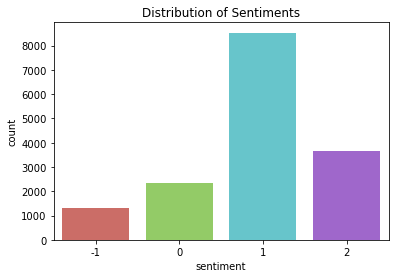

In [5]:
#the frequency distribution of the sentiments
#Thibello
sns.countplot(x = 'sentiment', data = data_sorted, palette="hls")
plt.title("Distribution of Sentiments")

In [6]:
#counting the number of respective impurities

punctuations = 0
numbers = 0

for i in data_sorted["message"]:
    for k in i.split():
        if k in string.punctuation:
            punctuations+=1
        if k.isdigit():
            numbers += 1
print("punctuations present in the tweets:", punctuations)
print("numbers present in the tweets:", numbers)


punctuations present in the tweets: 1440
numbers present in the tweets: 1111


## 4. Pre-processing
[Back to Table of Contents](#Table-of-Contents)

### Revise data 

In [7]:
#making the tweetid the index
data = pd.read_csv("train.csv", index_col = "tweetid")
data.head(3)


,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...


In [8]:
#rearrange the columns for clarity
data_sorted = data[["message", "sentiment"]]
data_sorted.head(3)

,message,sentiment
tweetid,,
625221,PolySciMajor EPA chief doesn't think carbon di...,1
126103,It's not like we lack evidence of anthropogeni...,1
698562,RT @RawStory: Researchers say we have three ye...,2


## Removing the Noise

### Lowercasing the data

In [9]:
#make everything lower case
'''
Converting every letter into lowercase helps to understand better what the words 
state.
'''
data_sorted['message'] = data_sorted['message'].str.lower()
data_sorted.head(3)

,message,sentiment
tweetid,,
625221,polyscimajor epa chief doesn't think carbon di...,1
126103,it's not like we lack evidence of anthropogeni...,1
698562,rt @rawstory: researchers say we have three ye...,2


### Removing Contractions

In [10]:
#expand all existing contractions

def expand_contractions(tweet):
    return " ".join([contractions.fix(c) for c in tweet.split()])

data_sorted["message"] = data_sorted["message"].apply(expand_contractions)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt @rawstory: researchers say we have three ye...,2
573736,#todayinmaker# wired : 2016 was a pivotal year...,1
466954,"rt @soynoviodetodas: it is 2016, and a racist,...",1


### Removing all hyperlinks(web urls)

In [11]:
#remove web urls 
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
data_sorted['message'] = data_sorted['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

### Removing Punctuations

Removing punctuation marks assists us to treat every word equally, 
E.g sweet! and sweet are the same without punctuation. 

In [12]:
#remove all punctuations

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

data_sorted['message'] = data_sorted['message'].apply(remove_punctuation)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt rawstory researchers say we have three year...,2
573736,todayinmaker wired 2016 was a pivotal year in...,1
466954,rt soynoviodetodas it is 2016 and a racist sex...,1


### Removing Numbers

"For example, when we are doing sentiment analysis then the number doesn’t hold any specific meaning to the data but if the task is to perform NER (Name Entity Recognition) or POS (Part of Speech tagging) then use the removing of number technique carefully."

In [13]:
def remove_digits(post):
    return ''.join([i for i in post if not i.isdigit()])

data_sorted['message'] = data_sorted['message'].apply(remove_digits)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt rawstory researchers say we have three year...,2
573736,todayinmaker wired was a pivotal year in the...,1
466954,rt soynoviodetodas it is and a racist sexist ...,1


### Removing Extra Space

Removing expace could help reduce the memory usage 

In [14]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   sentiment  15819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


In [15]:
def remove_extra_space(text):
    return " ".join(text.split())

data_sorted['message'] = data_sorted['message'].apply(remove_extra_space)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt rawstory researchers say we have three year...,2
573736,todayinmaker wired was a pivotal year in the w...,1
466954,rt soynoviodetodas it is and a racist sexist c...,1


In [16]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   sentiment  15819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


### Removing the repetitions of Punctuations 

In [17]:
def remove_rep_signs(text):
    return re.sub(r'(!|.)1+', '', text)

data_sorted['message'] = data_sorted['message'].apply(remove_rep_signs)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt rawstory researchers say we have three year...,2
573736,todayinmaker wired was a pivotal year in the w...,1
466954,rt soynoviodetodas it is and a racist sexist c...,1


### Removing Emojis

In [18]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"U0001F600-U0001F64F"  # emoticons
                           u"U0001F300-U0001F5FF"  # symbols & pictographs
                           u"U0001F680-U0001F6FF"  # transport & map symbols
                           u"U0001F1E0-U0001F1FF"  # flags (iOS)
                           u"U00002702-U000027B0"
                           u"U000024C2-U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
data_sorted['message'] = data_sorted['message'].apply(remove_emoji)
data_sorted.head()

,message,sentiment
tweetid,,
625221,polyscimajor epa chief does not think carbon d...,1
126103,it is not like we lack evidence of anthropogen...,1
698562,rt rawstory researchers say we have three year...,2
573736,todayinmaker wired was a pivotal year in the w...,1
466954,rt soynoviodetodas it is and a racist sexist c...,1


### Removing Emoticons

def remove_emoticons(string):
    EMOTICONS = {
            u":‑)":"Happy face or smiley",
            u":)":"Happy face or smiley",
            u":-]":"Happy face or smiley",
            u":]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-)":"Happy face smiley",
            u":o)":"Happy face smiley",
            u":-":"Happy face smiley",
            u":}":"Happy face smiley",
            u":-)":"Happy face smiley",
            u":c)":"Happy face smiley",
            u":^)":"Happy face smiley",
            u"=]":"Happy face smiley"
            }
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')') 
    return emoticon_pattern.sub(r'',text) 

data_sorted['message'] = data_sorted['message'].apply(remove_emoticons)
data_sorted.head()            
 

EMOTICONS = {
            u":‑)":"Happy face or smiley",
            u":)":"Happy face or smiley",
            u":-]":"Happy face or smiley",
            u":]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-)":"Happy face smiley",
            u":o)":"Happy face smiley",
            u":-":"Happy face smiley",
            u":}":"Happy face smiley",
            u":-)":"Happy face smiley",
            u":c)":"Happy face smiley",
            u":^)":"Happy face smiley",
            u"=]":"Happy face smiley"
            }

def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text


data_sorted['message'] = data_sorted['message'].apply(convert_emoticons)
data_sorted

### Tokenizerization

In [19]:
#tokenisation to treat each word with respect
tokeniser = TreebankWordTokenizer()
data_sorted['message'] = data_sorted['message'].apply(tokeniser.tokenize)

data_sorted

,message,sentiment
tweetid,,
625221,"[polyscimajor, epa, chief, does, not, think, c...",1
126103,"[it, is, not, like, we, lack, evidence, of, an...",1
698562,"[rt, rawstory, researchers, say, we, have, thr...",2
573736,"[todayinmaker, wired, was, a, pivotal, year, i...",1
466954,"[rt, soynoviodetodas, it, is, and, a, racist, ...",1
...,...,...
22001,"[rt, ezlusztig, they, took, down, the, materia...",1
17856,"[rt, washingtonpost, how, climate, change, cou...",2
384248,"[notiven, rt, nytimesworld, what, does, trump,...",0


### Removing Stop Words

In [20]:
#remove standard stop words, which are words of insignificance
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

data_sorted['message'] = data_sorted['message'].apply(remove_stop_words)
data_sorted

,message,sentiment
tweetid,,
625221,"[polyscimajor, epa, chief, think, carbon, diox...",1
126103,"[like, lack, evidence, anthropogenic, global, ...",1
698562,"[rt, rawstory, researchers, say, three, years,...",2
573736,"[todayinmaker, wired, pivotal, year, war, clim...",1
466954,"[rt, soynoviodetodas, racist, sexist, climate,...",1
...,...,...
22001,"[rt, ezlusztig, took, material, global, warmin...",1
17856,"[rt, washingtonpost, climate, change, could, b...",2
384248,"[notiven, rt, nytimesworld, trump, actually, b...",0


### Stemmer

In [21]:
#stem to transform to the root word, and have more common words
stemmer = SnowballStemmer('english')

def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_stemmer, args=(stemmer, ))
data_sorted

,message,sentiment
tweetid,,
625221,"[polyscimajor, epa, chief, think, carbon, diox...",1
126103,"[like, lack, evid, anthropogen, global, warm]",1
698562,"[rt, rawstori, research, say, three, year, act...",2
573736,"[todayinmak, wire, pivot, year, war, climat, c...",1
466954,"[rt, soynoviodetoda, racist, sexist, climat, c...",1
...,...,...
22001,"[rt, ezlusztig, took, materi, global, warm, lg...",1
17856,"[rt, washingtonpost, climat, chang, could, bre...",2
384248,"[notiven, rt, nytimesworld, trump, actual, bel...",0


### Lemmatization 

In [22]:
#lemmatization to lessen unique words even more by changing tenses of words and plurals
lemmatizer = WordNetLemmatizer()

def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_lemma, args=(lemmatizer, ))

data_sorted

,message,sentiment
tweetid,,
625221,"[polyscimajor, epa, chief, think, carbon, diox...",1
126103,"[like, lack, evid, anthropogen, global, warm]",1
698562,"[rt, rawstori, research, say, three, year, act...",2
573736,"[todayinmak, wire, pivot, year, war, climat, c...",1
466954,"[rt, soynoviodetoda, racist, sexist, climat, c...",1
...,...,...
22001,"[rt, ezlusztig, took, materi, global, warm, lg...",1
17856,"[rt, washingtonpost, climat, chang, could, bre...",2
384248,"[notiven, rt, nytimesworld, trump, actual, bel...",0


In [23]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   sentiment  15819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


import emojis 
emojis.count() 

In [59]:
data = [item += item for item in data_sorted['message']]
print(data)

SyntaxError: invalid syntax (3990496987.py, line 1)

In [26]:
start_list = ['using', 'list', 'comprehension']
string = ' '.join([str(item) for item in start_list])
print(string)

using list comprehension


## 5. Feature Engineering
[Back to Table of Contents](#Table-of-Contents)

### N-grams

In [27]:
from nltk.util import ngrams

In [28]:
def word_grams(words, min_n=1, max_n=4):
    s = []
    for n in range(min_n, max_n):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [29]:
print (word_grams(str(data_sorted['message']).split(' ')))

['tweetid\n625221', '', '', '', '[polyscimajor,', 'epa,', 'chief,', 'think,', 'carbon,', 'diox...\n126103', '', '', '', '', '', '', '', '[like,', 'lack,', 'evid,', 'anthropogen,', 'global,', 'warm]\n698562', '', '', '', '[rt,', 'rawstori,', 'research,', 'say,', 'three,', 'year,', 'act...\n573736', '', '', '', '[todayinmak,', 'wire,', 'pivot,', 'year,', 'war,', 'climat,', 'c...\n466954', '', '', '', '[rt,', 'soynoviodetoda,', 'racist,', 'sexist,', 'climat,', 'c...\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '...', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '\n22001', '', '', '', '', '[rt,', 'ezlusztig,', 'took,', 'materi,', 'global,', 'warm,', 'lg...\n17856', '', '', '', '', '[rt,', 'washingtonpost,', 'climat,', 'chang,', 'could,', 'bre...\n384248', '', '', '', '[notiven,', 'rt,', 'nytimesworld,', 'trump,', 'actual,', 'bel...\n819732', '', '', '', '[rt,', 

### Bag of Words 

## 6. Modelling
[Back to Table of Contents](#Table-of-Contents)

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y = data_sorted['sentiment']
X = data_sorted['message']

#Standarise the data
standard_scaler = StandardScaler()
X_transformed = standard_scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.30, random_state=50)

tree = DecisionTreeClassifier(random_state=42)

## 7. Conclusion
[Back to Table of Contents](#Table-of-Contents)

In [64]:
dict = {'ls1': ['me', 'too'], ['yeah','alright'],
        'ls2': ['c', 'd']}
data = pd.DataFrame(dict)
#ls3 = [item += item for item in  ]
#[item += item for item in data_sorted['message']]
print(data)

SyntaxError: invalid syntax (797043161.py, line 1)

In [52]:
dict75 = {'name':['aparna', 'pankaj', 'sudhir', 'Geeku'], 'degree': ['MBA', 'BCA', 'M.Tech', 'MBA'], 'score':[90, 40, 80, 98]}

df75 = pd.DataFrame(dict75)
df75

,name,degree,score
0,aparna,MBA,90
1,pankaj,BCA,40
2,sudhir,M.Tech,80
3,Geeku,MBA,98


In [54]:
for key, value in df75['degree'].iterrows():
    print(value)

AttributeError: 'Series' object has no attribute 'iterrows'

In [65]:
pip install emoji

  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=d2c6749d2098d5f05dc4bf83c3cfb711b9935e385a8baf657e15003fd24c1be8
  Stored in directory: c:\users\sweet pea\appdata\local\pip\cache\wheels\9a\b8\0f\f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


In [1]:
import emoji
print(emoji.emojize('Python is :thumbs_up:'))

Python is 👍


In [3]:
pip install clean-text

ERROR: unknown command " install clean-text"

